# Tittel
### Av ...
## FYS-STK4155/3155

### Dato

### Part a)

-----Calculations wit descriptions---

For following sections, different models are generated and fitted to a dataset made from the Franke fucntion. 

### Part b)  Ordinary Least Square (OLS) on the Franke function

A Franke function was used to generate at dataset from random variables between 0 and 1. The output values of the Franke function was used as dependent varaibles (z), while the independent variable x was used to generate these values. This provided us with sufficient starting point for machine learning analysis. The aim was to generate a model z ̃ that can function as a predictor of the dependent variables. In a linear regression the assuption is that z~ can be given by some linear function f that takes the independent input variables, with some added variablity given by an estimated ε. This can be written as follows. 
$$
z ̃ = f ( x ) + ε 
$$

mean-squared error (MSE)

A model was generated by constructing a design matrix from the input varaibles. With *n* datapoints and *p* features, a design matrix can be constructed of dimentions *n*x*p*. Each 

To generate the model, a design matrix is con- structed from the input variables. Given p features and n datapoints, a design matrix of dimension n × p is constructed. This can be done in many ways, depending on the assumptions made about the dependency of the response variables on the features. In this project, the Vandermonde matrix was used. The two data-sets studied both contained two independent variables, x and y, and one depen- dent variable, z, so the design-matrix was given by the following expression:

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [69]:
#tatt fra prosjekt beskrivelsen
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + np.random.normal(0, 0.1, x.shape)

In [70]:
#Begge er definert i oppgave b, de ulike begrepene er også forklart kort der
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model)**2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

Lånt fra forelesning notater

In [71]:
#Hentet fra forelesnings notater uke 35 under "More preprocessing examples, Franke function and regression"
def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x) # flattens the matrices
        y = np.ravel(y)

    N = len(x) #number of x-variables, datapoints
    l = int((n+1)*(n+2)/2)     # Number of elements in beta - parameters, features
    X = np.ones((N,l)) #Making a matrix of dimentions given by the number of variables and number of parameters

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

In [72]:
#lager 2000 datapunkter, i eksemplet i prosjekt besrkivelsen er det kun 20
#Siden vi har så mange datapunkter vil forskjellen på med og uten resampling være liten
size = 1000
noise = 0.05 # Level of noise
x = np.arange(0, 1, 1/size)
y = np.arange(0, 1, 1/size)
#x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)
z += (np.random.randn(size)*noise) #Added noise

En funksjon for å finne beta med pseudo inversering av matrise.
Beta er definert som:
\begin{equation}
    \hat{\beta}=(X^T X)^{-1}X^T z
\end{equation}

In [73]:
def find_beta(X, z): #Takes the 
    XT = X.T
    #np.linalg.pinv blir brukt istedenfor np.linalg.inv fordi vi ikke kan garantere
    #at XT @ X er iversibel (kan ha determinant = 0)
    XTXinv = np.linalg.pinv(np.matmul(XT, X))
    XTz = np.matmul(XT, z)
    beta = np.matmul(XTXinv, XTz)

    return beta

#### Scaling

In [84]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def standardscaler(X_train, X_test, z_train, z_test): 
    #Using Sci-kit learn standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    # Scaling independent variable
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #scaling response variable
    z_train_scaled = (z_train - np.mean(z_train))/np.std(z_train)
    z_test_scaled = (z_test - np.mean(z_train))/np.std(z_train)

    return X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled

def meanscaler(X_train, X_test, z_train, z_test):
    #Taking the mean of the data
    mean_X = np.mean(X_train, axis=0)
    mean_z = np.mean(z_train)
    #Subtract mean from all data points
    X_train_scaled = X_train - mean_X
    X_test_scaled = X_test - mean_X
    z_train_scaled = z_train - mean_z
    z_test_scaled = z_test - mean_z
    
    return X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled

    
def scalerMinMax(X_train, X_test, z_train, z_test):
    #Using Sci-kit learn min-max scaler
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    z_test_scaled = (z_test - np.mean(z_train))/np.std(z_train)
    #Scaling independent varaible
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #reshape response varible to be scaled
    z_train = z_train.reshape((-1,1))
    z_test = z_test.reshape((-1,1))
    #Scaling response variable
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(z_train)
    z_train_scaled = scaler.transform(z_train)
    scaler = MinMaxScaler(feature_range=(0,1)).fit(z_train)
    z_test_scaled = scaler.transform(z_test)
    # reshaping
    z_train_scaled.flatten()
    z_test_scaled.flatten()
    
    
    return X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled

def robustscaler(X_train, X_test, z_train, z_test):
     #Using Sci-kit learn robust scaler
    scaler = RobustScaler().fit(X_train)
    #scaling independent variable
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Scaling response variable
    z_train = z_train.reshape((-1,1))
    z_test = z_test.reshape((-1,1))
    scaler = RobustScaler().fit(z_train)
    z_train_scaled = scaler.transform(z_train)
    scaler = RobustScaler().fit(z_train)
    z_test_scaled = scaler.transform(z_test)
    z_train_scaled = z_train_scaled.flatten()
    z_test_scaled = z_test_scaled.flatten()
    
    return X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled

def nonscaler(X_train, X_test, z_train, z_test):
    return(X_train, X_test, z_train, z_test)
    


#### Testing model for different polynomial degrees
It is crucial to find the right polynomial degree in a polynomial linear regression. A too high degree may lead to overfitting, while a too small degree may lead to underfitting. 

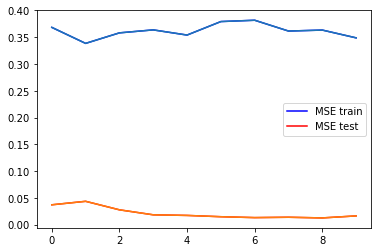

In [85]:
maxdegree = 10
#En array med tall fra 1 til maxdegree som er garantert typen int (for at vi kan bruke det til å indeksere)
degrees = np.linspace(1, maxdegree, maxdegree, dtype=int)

scores_OLS_basic = np.zeros((maxdegree, 2))
scores_OLS_basic_train = np.zeros((maxdegree, 2))
for degree in degrees:
    #Lager feature matrisen vår X
    X = create_X(x, y, degree)
    #Splits 1/5 for testing and 4/5 for training
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    #finner beta
    beta = find_beta(X_train, z_train)
    #Her er z_ vår forutsigelse
    z_ = X_test @ beta
    trained_z = X_train @ beta
    
    #Find estimated of quality of fmodel fit 
    scores_OLS_basic[degree-1, 0] = MSE(z_test, z_)#np.sqrt() Fjernet dette fordi oppgaven ber om bare MSE 
    scores_OLS_basic[degree-1, 1] = R2(z_test, z_)
    scores_OLS_basic_train[degree-1, 0] = MSE(z_train, trained_z)#np.sqrt()
    scores_OLS_basic_train[degree-1, 1] = R2(z_train, trained_z)

df1 = pd.DataFrame(scores_OLS_basic, columns = ('MSE test', 'R2 test')) 
df2 = pd.DataFrame(scores_OLS_basic_train, columns = ('MSE train', 'R2 train'))

df = pd.concat([df1, df2], axis =1)
df['degree'] = degrees

fig, ax = plt.subplots()
train, = ax.plot(df.index, df['MSE train'], color = 'blue')
test, = ax.plot(df.index, df['MSE test'], color = 'red')
plt.legend([train, test],['MSE train', 'MSE test'])
plt.plot(df.index, df['MSE train'])
plt.plot(df.index, df['MSE test'])


In [76]:
small_MSE = min(scores_OLS_basic[:, 0])
MSEs = scores_OLS_basic[:, 0].tolist()
large_R2 = max(scores_OLS_basic[:, 1])
R2s = scores_OLS_basic[:, 1].tolist()
print(f'smallest MSE score is {small_MSE} which is at degree {MSEs.index(small_MSE)+1}')
print(f'smallest R2 score is {large_R2} which is at degree {R2s.index(large_R2)+1}')


smallest MSE score is 0.012172724163986494 which is at degree 10
smallest R2 score is 0.9359345657253902 which is at degree 10


In [77]:
#Scikit learn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

scores_OLS_sklearn = np.zeros((maxdegree, 2))
for i , d in enumerate(degrees):
    
    poly = PolynomialFeatures(degree=d, include_bias=False)
    
    poly_reg_model = LinearRegression()
    poly_features = poly.fit_transform(x.reshape(-1, 1))
    X_train, X_test, z_train, z_test = train_test_split(poly_features,z,test_size=0.2)
    poly_reg_model.fit(X_train, z_train)
    sk_z_pred = poly_reg_model.predict(X_test)
    
    

    scores_OLS_sklearn[i, 0] = MSE(z_test, sk_z_pred) 
    scores_OLS_sklearn[i, 1] = R2(z_test, sk_z_pred)
    
df3 = pd.DataFrame(scores_OLS_sklearn, columns = ('MSE sklearn', 'R2 sklearn'))
df = pd.concat([df, df3], axis =1)
df = df[['degree', 'MSE train', 'MSE test', 'MSE sklearn','R2 train', 'R2 test', 'R2 sklearn']].set_index('degree')
display(df)
small_MSE = min(scores_OLS_sklearn[:, 0])
MSEs = scores_OLS_sklearn[:, 0].tolist()
best_degree = MSEs.index(small_MSE)+1


,MSE train,MSE test,MSE sklearn,R2 train,R2 test,R2 sklearn
degree,,,,,,
1,0.041495,0.049171,0.040387,0.777110,0.740447,0.763840
2,0.043100,0.040035,0.048835,0.772477,0.777105,0.763446
3,0.026480,0.026881,0.028824,0.860069,0.846319,0.851579
4,0.017800,0.016395,0.018298,0.903977,0.916246,0.897793
5,0.018351,0.014038,0.016785,0.903830,0.918506,0.915301
6,0.014977,0.015175,0.011889,0.920808,0.915560,0.924927
7,0.013207,0.014213,0.014393,0.929902,0.922683,0.921566
8,0.013236,0.014142,0.012939,0.930626,0.918839,0.932458
9,0.013043,0.012748,0.012672,0.931629,0.926860,0.927396


In [78]:
print('The polynomial degree that will be used is: ', best_degree, '\n - based on scikit-learn')

The polynomial degree that will be used is:  6 
 - based on scikit-learn


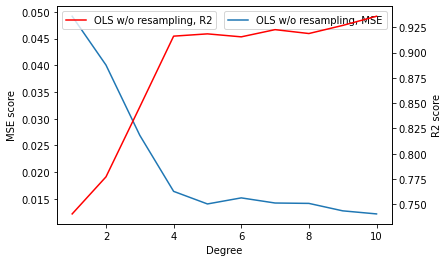

In [79]:
#Plotting the non-rasampled MSE and R2 scores in one plot
fig, ax = plt.subplots()
x_ax, y_ax =  zip(*sorted(zip(degrees, scores_OLS_basic[:, 0])))
ax.plot(x_ax, y_ax, label="OLS w/o resampling, MSE") #degrees, scores_OLS_basic[:, 0]
ax.set_xlabel("Degree")
plt.ylabel("MSE score")
plt.legend()
ax2 = ax.twinx()
x_ax, y_ax =  zip(*sorted(zip(degrees, scores_OLS_basic[:, 1])))
ax2.plot(x_ax, y_ax, label="OLS w/o resampling, R2", c = 'r')
plt.xlabel("Degree")
ax2.set_ylabel("R2 score")
plt.legend()

We find the highest R2 values are acheved around 4 degrees, and the lowest MSE score at the same value. A lower MSE score indicates a better model fit, as it indicates that the variation in the real data around the predicted values of the model is small. The R2 score indicates how much of the variance in the data that can be explained by the model, meaning that a high R2 is a signature of a good model fit. We can therefore infer that in this case we acheved the best fit of the model to the Franke function with a 4 degree polynomial linear regression.

In [86]:
func_list = [standardscaler, meanscaler, scalerMinMax, robustscaler, nonscaler]
scores_OLS_scaled = np.zeros((len(func_list), 2))


X = create_X(x, y, best_degree)

for i, func in enumerate(func_list):

    #Splits 1/5 for testing and 4/5 for training
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled = func(X_train, X_test, z_train, z_test)

    #finner beta
    beta = find_beta(X_train_scaled, z_train_scaled)
    #Her er z_ vår forutsigelse
    z_ = X_test_scaled @ beta

    #Find estimated of quality of fmodel fit 
    scores_OLS_scaled[i, 0] = MSE(z_test_scaled, z_)
    scores_OLS_scaled[i, 1] = R2(z_test_scaled, z_)

d1 = pd.DataFrame(scores_OLS_scaled, columns = ('MSE test', 'R2 test')) 
d = pd.concat([d1], axis =1)
names = ['Standard', 'Mean', 'MinMax', 'Robustscaler', 'None']
d['scaler'] = names
d[['scaler', 'MSE test','R2 test']].set_index('scaler')
display(d)
print('NOT RIGHT!!!', '\n These values should be pretty much the same')

,MSE test,R2 test,scaler
0,0.089410,0.907272,Standard
1,0.014608,0.919209,Mean
2,0.010309,0.816722,MinMax
3,0.027947,0.909412,Robustscaler
4,0.011612,0.934174,None


NOT RIGHT!!! 
 These values should be pretty much the same


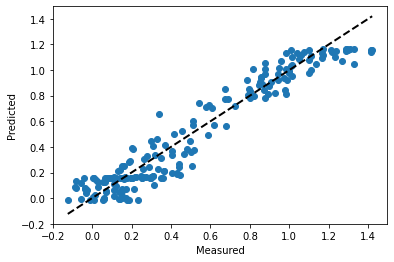

In [81]:
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

beta = find_beta(X_train, z_train)
z_ = X_test @ beta

d = {'true': np.array(z_test).flatten(), 'predicted': z_.flatten()}

df = pd.DataFrame(data=d)
df['diff'] = df['predicted'] - df['true']

fig, ax = plt.subplots()
ax.scatter(df['true'], df['predicted'])
ax.plot([df['true'].min(), df['true'].max()], [df['true'].min(), df['true'].max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Part c)

In [82]:
#En iterasjon av bootstrap. finner gjennomsnittet ved alle kolonnene fra en tilfeldig sampling av feature matrisen
#samplingen blir gjort tilfeldig med erstatning, altså kan f.eks X[0][0] blir valgt flere eller ingen ganger
'''def bootstrap(feature, data):
    n = len(data)
    data_temp = np.zeros(n)
    feature_temp = np.zeros(n)
    
    #lager en array med tilfeldige integers fra 0 til n, samme tall kan dukke opp flere ganger
    indices = np.random.randint(0, n, n)
    
    #tar gjennomsnitt
    data_temp = np.mean(data[indices])
    #siden feature matrisen er 2D ønsker vi kun å ta gjennomsnitt langs en og en kolonne (ikke hele matrisen på en gang)
    feature_temp = np.mean(feature[indices], axis=0)
    return feature_temp, data_temp'''

# This is a verison of a non-parametric bootstrapping method that takes the real data and number of datapoints to generate 
# The lenght of the data decides 

def bootstrap(data, datapoints):
    t = np.zeros(datapoints) 
    n = len(data)  
    for i in range(datapoints):
        rand_data = data[np.random.randint(0,n,n)] # select at random from the data with replacement a equally large data set
        t[i] = np.mean(rand_data, axis=0) # take the mean of this new data set
    return t # returns a dataset consisting of the mean of each iteration 

#Third attempt
# This bootstrapping fucntion will return y_pred
# It will take the desired number of iterations (500-1000, ideally) and for each iteration make resampled set of 
# x and y values of the same lenght as the original x and y datasets provided
# Each iteration 
'''def boot(x, y, n_boots)
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(x_train, y_train)

        # Evaluate the new model on the same test data each time.
        y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()
        
    return()'''

'def boot(x, y, n_boots)\n    y_pred = np.empty((y_test.shape[0], n_boostraps))\n    for i in range(n_boostraps):\n        x_, y_ = resample(x_train, y_train)\n\n        # Evaluate the new model on the same test data each time.\n        y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()\n        \n    return()'

In [62]:
#Ønsker å bevare scoren, "list"[:, 0] inneholder RMSE, "list"[:, 1] inneholder R2
scores_OLS_boot = np.zeros((maxdegree, 2))
for degree in degrees:
    #ganske likt som tidligere
    #X = create_X(x, y, degree)
    #X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    
    #vi sampler B ganger, B burde være omtrent like stor eller større enn antall datapunkter
    #Vi ønsker å ta ibruk sentral grense teoremet
    B = len(z_train)
    #z_train_boot = np.zeros(B)
    #X_train_boot = np.zeros(X_train.shape)
    #her fyller vi sakte opp vår nye feature matrise med gjennomsnittlige verdier
    #for i in range(B):
    #    X_train_boot[i], z_train_boot[i] = bootstrap(X_train, z_train)
    boot_n = 500
    boot_list = bootstrap(z_train,B) #bootstrapping the z-values to get a resampled set of the 'observed' data
    #beta = find_beta(X_train, z_train)
    print('BOOT LIST',len(boot_list))
    beta = find_beta(X_train, boot_list) #Using the same X-values, but the bootstrapped version of the z_train to find beta
    z_boot = X_test @ beta # Predicting outcome values from X-test based on the bootstrap derived parameters
    
    scores_OLS_boot[degree-1, 0] = MSE(z_test, z_boot)#np.sqrt()
    scores_OLS_boot[degree-1, 1] = R2(z_test, z_boot)
    print(f"Errors for degree {degree}:")
    print(f"RMSE[Bootstrap] = {scores_OLS_boot[degree-1, 0]}")
    print(f"RMSE[w/0 resampling] = {scores_OLS_basic[degree-1, 0]}")
    print(f"R2[Bootstrap] = {scores_OLS_boot[degree-1, 1]}")
    print(f"R2[w/o resampling] = {scores_OLS_basic[degree-1, 1]}")
    print(f"Improvement:")
    print(f"RMSE: {abs(scores_OLS_boot[degree-1, 0] - scores_OLS_basic[degree-1, 0])}")
    print(f"R2: {abs(scores_OLS_boot[degree-1, 1] - scores_OLS_basic[degree-1, 1])}\n")

error = scores_OLS_boot[maxdegree-1, 0]**2 #for each of the degrees, the MSE is used to get an error estimate
# finding the bias by subtractiong the mean of the bootstraped predictions from each test-data value,
# then calculating the mean of this - ideally it should be 0, indicating that the predictions are nomally distributed
# around the predictions
error = np.mean( np.mean((z_test - z_boot)**2, keepdims=True) )
bias = np.mean( (z_test - np.mean(z_boot))**2 )
variance = np.mean( np.var(z_boot) ) #Finds the mean variance of the 
print('Error:', error)
print('Bias^2:', bias)
print('Var:', variance)
print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))


BOOT LIST 800
Errors for degree 1:
RMSE[Bootstrap] = 0.2056356574230869
RMSE[w/0 resampling] = 0.047192152351050766
R2[Bootstrap] = -0.005152633397577322
R2[w/o resampling] = 0.7566277682031765
Improvement:
RMSE: 0.15844350507203614
R2: 0.7617804016007538

BOOT LIST 800
Errors for degree 2:
RMSE[Bootstrap] = 0.2052454572747353
RMSE[w/0 resampling] = 0.03460491451362224
R2[Bootstrap] = -0.0032453245602741543
R2[w/o resampling] = 0.7946602596817018
Improvement:
RMSE: 0.17064054276111307
R2: 0.797905584241976

BOOT LIST 800
Errors for degree 3:
RMSE[Bootstrap] = 0.20545696102464503
RMSE[w/0 resampling] = 0.023869467129219616
R2[Bootstrap] = -0.0042791605878353955
R2[w/o resampling] = 0.8729340912390611
Improvement:
RMSE: 0.18158749389542542
R2: 0.8772132518268965

BOOT LIST 800
Errors for degree 4:
RMSE[Bootstrap] = 0.2038488960845124
RMSE[w/0 resampling] = 0.015975627102145295
R2[Bootstrap] = 0.0035811041614979278
R2[w/o resampling] = 0.9124088879319933
Improvement:
RMSE: 0.1878732689823

NOT RIGHT!!!


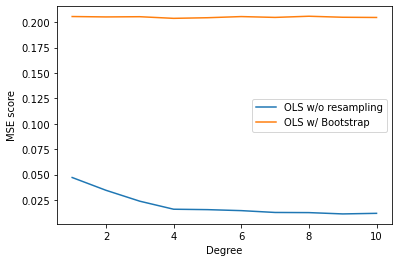

In [65]:
plt.plot(degrees, scores_OLS_basic[:, 0], label="OLS w/o resampling")
plt.plot(degrees, scores_OLS_boot[:, 0], label="OLS w/ Bootstrap")
plt.xlabel("Degree")
plt.ylabel("MSE score")
plt.legend()
print('NOT RIGHT!!!')

### Part d)

In [66]:
#metoden deler data settet inn i kfolds deler
#i tilfellet hvor kfolds=5, vil for hver iterasjon:
#4 av de bli brukt til trening og en siste til å teste
#deretter blir alt skiftet til høyre, slik at 
#del 4, som tidligere var brukt til trening, er nå den
#ene delen brukt til å teste. Neste iterasjon er det da
#del 3 sin tur, deretter del 2 og til slutt del 1
#altså får hver del muligheten til å brukes til testing
#vi retunerer scorene til alle delene, slik at
#scores[0] er scoren til del 5 som testing del.
#vi retunerer også de best scorende matrisene/arraysene
#for å kunne bruke senere
def cross_validation(feature, data, kfolds):
    n = len(data)
    #samme som tidligere, bare her uten replacement
    indices = np.random.choice(n, n, replacement=False)
    scores = np.zeros(kfolds)
    
    #definerer dimensjonene og størrelsene på de ulike delene
    fold_len = int(n/kfolds)
    feature_train = np.zeros([(kfolds-1)*fold_len, len(feature[0])])
    data_train = np.zeros((tkfolds-1)*fold_len)
    feature_test = np.zeros([fold_len, len(feature[0])])
    data_test = np.zeros(fold_len)
    feature_best = np.copy(feature_test)
    data_best = np.copy(data_train)
    data_test_best = np.copy(data_test)
    for i in range(kfolds):
        #De første fire delene sine indekser
        fold_indices = indices[:(kfolds-1)*fold_len]
        
        feature_train = feature[fold_indices]
        data_train = data[fold_indices]
        
        #den siste delens indekser
        test_fold_indices = indices[(kfolds-1)*fold_len:]
        
        feature_test = feature[test_fold_indices]
        data_test = data[test_fold_indices]
        
        #finner scorene
        beta = find_beta(feature_train, data_train)
        data_ = feature_test @ beta
        scores[i] = MSE(data_test, data_)
        #om i>0 er det automatisk den beste modellen så langt
        #if test nr.2 fungerer også ikke for i=0
        #den nye beste modellen blir lagret for senere bruk
        if i > 0:
            #sjekker om den nye scoren er bedre
            if scores[i] < scores[:i].min():
                feature_best = feature_test
                data_best = data_
                data_test_best = data_test
        else:
            feature_best = feature_test
            data_best = data_
            data_test_best = data_test
        
        #ruller indeksene til høyre, slik at den tidligere siste delen er nå først
        indices = np.roll(indices, fold_len)
        
    return scores, data_best, feature_best, data_test_best

In [67]:
#kfolds er ofte mellom 5 og 10
kfolds = 5
scores_OLS_CV = np.zeros((maxdegree, 2))
for degree in degrees:
    #denne gangen deler vi ikke inn i train og test
    #men vi kunne gjort det også, for enda et lag med vurdering
    #dette kan være nyttig for høye grader av maxdegree
    X = create_X(x, y, degree)
    
    scores, z_, X_test, z_test = cross_validation(X, z, kfolds)
    
    scores_OLS_CV[degree-1, 0] = np.sqrt(scores.min())
    scores_OLS_CV[degree-1, 1] = R2(z_test, z_)
    print(f"Errors for degree {degree}:")
    print(f"RMSE[CV] = {scores_OLS_CV[degree-1, 0]}")
    print(f"RMSE[w/0 resampling] = {scores_OLS_basic[degree-1, 0]}")
    print(f"R2[CV] = {scores_OLS_CV[degree-1, 1]}")
    print(f"R2[w/o resampling] = {scores_OLS_basic[degree-1, 1]}")
    print(f"Improvement:")
    print(f"RMSE: {scores_OLS_basic[degree-1, 0] - scores_OLS_CV[degree-1, 0]}")
    print(f"R2: {scores_OLS_CV[degree-1, 1] - scores_OLS_basic[degree-1, 1]}\n")

TypeError: choice() got an unexpected keyword argument 'replacement'

In [ ]:
plt.plot(degrees, scores_OLS_basic[:, 0], label="OLS w/o resampling")
plt.plot(degrees, scores_OLS_boot[:, 0], label="OLS w/ Bootstrap")
plt.plot(degrees, scores_OLS_CV[:, 0], label="OLS w/ CV")
plt.xlabel("Degree")
plt.ylabel("RMSE score")
plt.legend()

### Part e)

In [ ]:
#vi ønsker å bruke CV også for ridge og lasso, da må vi lage en versjon som tar hensyn til beta og 
#tar hensyn til hvilken metode som blir brukt
def cross_validation(feature, data, kfolds, lmbda, find_beta):
    n = len(data)
    indices = np.random.randint(0, n, n)
    scores = np.zeros(kfolds)
    
    fold_len = int(n/kfolds)
    feature_train = np.zeros([(kfolds-1)*fold_len, len(feature[0])])
    data_train = np.zeros((kfolds-1)*fold_len)
    feature_test = np.zeros([fold_len, len(feature[0])])
    data_test = np.zeros(fold_len)
    feature_best = np.copy(feature_test)
    data_best = np.copy(data_train)
    data_test_best = np.copy(data_test)
    for i in range(kfolds):
        fold_indices = indices[:(kfolds-1)*fold_len]
        
        feature_train = feature[fold_indices]
        data_train = data[fold_indices]
        
        test_fold_indices = indices[(kfolds-1)*fold_len:]
        
        feature_test = feature[test_fold_indices]
        data_test = data[test_fold_indices]
        
        beta = find_beta(feature_train, data_train, lmbda)
        data_ = feature_test @ beta
        scores[i] = MSE(data_test, data_)
        if i > 0:
            if scores[i] < scores[:i].min():
                feature_best = feature_test
                data_best = data_
                data_test_best = data_test
        else:
            feature_best = feature_test
            data_best = data_
            data_test_best = data_test
        
        indices = np.roll(indices, fold_len)
        
    return scores, data_best, feature_best, data_test_best

I ridge regression finner vi $\hat{\beta}$ ved:
\begin{equation}
    \hat{\beta}=(X^T X +\lambda I)^{-1}X^Tz
\end{equation}
Hvor $I$ er identitets matrisen og $\lambda$ er et valgt parameter

In [ ]:
#ridge regression demper outliers slik at de ikke påvirer alt for mye
def ridge_regression(X, z, lmbda):
    XT = X.T
    XTX = np.matmul(XT, X)
    XTXinv = np.linalg.pinv( XTX + lmbda*np.eye(len(XTX)))
    XTz = np.matmul(XT, z)
    beta = np.matmul(XTXinv, XTz)

    return beta

In [ ]:
#N er antall lambda verdier vi tester
N = 5
#fra 10^-4 til 10^4, tar kun verdier 10^n, hvor n er et heltall
lmbda = np.logspace(-4, 4, N)

scores_Ridge_boot = np.zeros((maxdegree, 2, N))
best_i = np.zeros(maxdegree, dtype=int)
for degree in degrees:
    X = create_X(x, y, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    
    #her utfører vi bootstrap
    B = len(z_train)
    z_train_boot = np.zeros(B)
    X_train_boot = np.zeros(X_train.shape)
    for i in range(B):
        X_train_boot[i], z_train_boot[i] = bootstrap(X_train, z_train)
        
    #itererer over alle lambda og bruker det feature matrise og data etter bootstrap
    for i, lmbda_ in enumerate(lmbda):
        beta = ridge_regression(X_train_boot, z_train_boot, lmbda_)
        z_ = X_test @ beta
        scores_Ridge_boot[degree-1, 0, i] = np.sqrt(MSE(z_test, z_))
        scores_Ridge_boot[degree-1, 1, i] = R2(z_test, z_)
        if i > 0:
            if scores_Ridge_boot[degree-1, 0, i] < scores_Ridge_boot[degree-1, 0, best_i[degree-1]]:
                best_i[degree-1] = i
        
    #her skal jeg legge inn slik at vi også gjør CV
    
    print(f"Errors for degree {degree}:")
    print(f"RMSE[Bootstrap] = {scores_Ridge_boot[degree-1, 0, best_i[degree-1]]}")
    print(f"RMSE[w/0 resampling] = {scores_OLS_basic[degree-1, 0]}")
    print(f"R2[Bootstrap] = {scores_Ridge_boot[degree-1, 1, best_i[degree-1]]}")
    print(f"R2[w/o resampling] = {scores_OLS_basic[degree-1, 1]}")
    print(f"Improvement:")
    print(f"RMSE: {scores_OLS_basic[degree-1, 0] - scores_Ridge_boot[degree-1, 0, best_i[degree-1]]}")
    print(f"R2: {scores_Ridge_boot[degree-1, 1, best_i[degree-1]] - scores_OLS_basic[degree-1, 1]}\n")

#fortsatt ikke implementer
"""for i in range(N):
    error = scores_Ridge_boot[maxdegree-1, 0, i]**2
    bias = np.mean( (z_test_ridge - np.mean(z_ridge))**2 )
    variance = np.mean( np.var(z_) )
    print('Error:', error)
    print('Bias^2:', bias)
    print('Var:', variance)
    print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))"""

In [ ]:
#Vi ønsker å kunne vise hvordan erroren utvikler seg
#plottet vil oppdatere seg avhengig av N
fig, ax = plt.subplots(int(N/2), int(N/2)+N%2, figsize= (12, 12))

for i in range(N):
    ax.flatten()[i].plot(degrees, scores_OLS_basic[:, 0], label="OLS w/o resampling")
    ax.flatten()[i].plot(degrees, scores_OLS_boot[:, 0], label="OLS w/ Bootstrap")
    ax.flatten()[i].plot(degrees, scores_OLS_CV[:, 0], label="OLS w/ CV")
    ax.flatten()[i].plot(degrees, scores_Ridge_boot[:, 0, i], label="Ridge w/ Bootstrap")
    ax.flatten()[i].set_xlabel("Degree")
    if i%(int(N/2)+1) == 0:
        ax.flatten()[i].set_ylabel("RMSE score")
    ax.flatten()[i].set_title(fr"$\lambda = ${lmbda[i]}")
    

handles, labels = ax.flatten()[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

### Part f)

In [ ]:
from sklearn import linear_model
#vi får lov til å bruke sklearn endelig
def lasso_regression(X, z, lmbda):
    RegLasso = linear_model.Lasso(lmbda, fit_intercept=False)
    RegLasso.fit(X, z)
    #dette retunerer beta hat
    return RegLasso.coef_

#en form for skalering, den sentrerer rundt x=y=0
#vi burde inkludere dette mye tidligere også
def meanscaler(X):
    return X-np.mean(X, axis=0)

In [ ]:
#ganske likt som for ridge, bare bruker lasso regression istedenfor
#lasso regression fjerner outliers med for stort utslag
N = 5
lmbda = np.logspace(-4, 4, N)

scores_Lasso_boot = np.zeros((maxdegree, 2, N))
best_i = np.zeros(maxdegree, dtype=int)
for degree in degrees:
    X = create_X(x, y, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    #X_train, X_test = meanscaler(X_train), meanscaler(X_test)
    
    B = len(z_train)
    z_train_boot = np.zeros(B)
    X_train_boot = np.zeros(X_train.shape)
    for i in range(B):
        X_train_boot[i], z_train_boot[i] = bootstrap(X_train, z_train)
        
    for i, lmbda_ in enumerate(lmbda):
        beta = lasso_regression(X_train_boot, z_train_boot, lmbda_)
        z_ = X_test @ beta
        scores_Lasso_boot[degree-1, 0, i] = np.sqrt(MSE(z_test, z_))
        scores_Lasso_boot[degree-1, 1, i] = R2(z_test, z_)
        if i > 0:
            if scores_Lasso_boot[degree-1, 0, i] < scores_Lasso_boot[degree-1, 0, best_i[degree-1]]:
                best_i[degree-1] = i
    
    print(f"Errors for degree {degree}:")
    print(f"RMSE[Lasso w/ Bootstrap] = {scores_Lasso_boot[degree-1, 0, best_i[degree-1]]}")
    print(f"RMSE[OLS w/0 resampling] = {scores_OLS_basic[degree-1, 0]}")
    print(f"R2[Lasso w/ Bootstrap] = {scores_Lasso_boot[degree-1, 1, best_i[degree-1]]}")
    print(f"R2[OLS w/o resampling] = {scores_OLS_basic[degree-1, 1]}")
    print(f"Improvement:")
    print(f"RMSE: {scores_OLS_basic[degree-1, 0] - scores_Lasso_boot[degree-1, 0, best_i[degree-1]]}")
    print(f"R2: {scores_Lasso_boot[degree-1, 1, best_i[degree-1]] - scores_OLS_basic[degree-1, 1]}\n")

### Part g)